# 1. Inferencing CLIP
한 시간 안에 CLIP 모델을 만들고 학습하는 것은 불가능하기 때문에 이미 완성된 모델로 실습을 진행하겠습니다.

### Transformers 라이브러리를 사용해봅시다.
<p align="center">
<a href="https://huggingface.co/transformers/">
<img src="https://huggingface.co/landing/assets/transformers-docs/huggingface_logo.svg" width="200px"></img></a>
</p>
<p align="center"> <a href="https://huggingface.co/transformers/"> Transformers </a> </p>



In [1]:
!pip install transformers


[notice] A new release of pip available: 22.1.2 -> 22.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Transformers 라이브러리에서 사전에 구현이 되어 있는 CLIP 모델과, 이미지-텍스트 전처리기를 로딩합니다.

저희가 사용할 CLIP 모델은 (CLIPModel) 은 내부적으로 PyTorch로 구현되어 있고, API 사용법과 내부 코드는 다음 웹사이트를 참고해주세요.
* https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPModel

이미지-텍스트 프리프로세서 (CLIPProcessor) 는 PIL 이미지와, string 으로 된 text를 받아서, CLIP 모델의 입력으로 쓸 수 있는 형태로 변환합니다.

CLIP 모델의 Text Encoder 와 Image Encoder 는 각각 어떤 모델로 구현되어 있는지 기억하시나요? 해당 모델들에 입력으로 사용할 이미지 또는 텍스트는 어떤 프리프로세싱을 필요로 하는지 생각해봅시다.

API 사용법과 내부 코드는 다음 웹사이트를 참고해주세요.

* https://huggingface.co/docs/transformers/v4.19.4/en/model_doc/clip#transformers.CLIPProcessor
* https://huggingface.co/docs/transformers/v4.19.4/en/model_doc/clip#transformers.CLIPFeatureExtractor
* https://huggingface.co/docs/transformers/v4.19.4/en/model_doc/clip#transformers.CLIPTokenizer


In [1]:
from transformers import CLIPProcessor
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

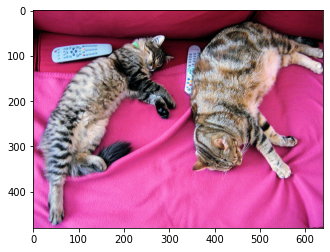

In [2]:
from PIL import Image
import requests

import matplotlib.pyplot as plt

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
plt.imshow(image)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dict_keys(['input_ids', 'attention_mask', 'pixel_values'])
tensor([[49406,  1237,  3989,   631,  6982, 49407, 49407],
        [49406,   320, 16464,   533,  4928,   519, 49407],
        [49406,  1237,  3255,   631, 32676, 49407, 49407]])
torch.Size([3, 7])
torch.Size([3, 7])
torch.Size([1, 3, 224, 224])


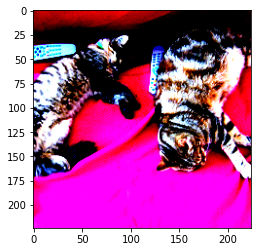

In [3]:
text_list = ["two cats are sleeping", "a dolphin is swiming", "two dogs are barking"]

inputs = processor(text=text_list, images=image, return_tensors="pt", padding=True)
print(inputs.keys())
print(inputs.input_ids)
print(inputs.input_ids.shape)
print(inputs.attention_mask.shape)
print(inputs.pixel_values.shape)
plt.imshow(inputs.pixel_values.numpy().squeeze(0).transpose(1, 2, 0))
plt.show()

OpenAI에서 공개한 가중치를 활용하여 CLIP 모델을 사용하여 봅시다.
* https://huggingface.co/openai/clip-vit-base-patch32

In [4]:
from transformers import CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
model.cuda()

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0): CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05, element

In [5]:
import torch
inputs = {key: tensor.cuda() for key, tensor in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)

logits_per_image = outputs.logits_per_image
probs = logits_per_image.softmax(dim=1)

print(outputs.image_embeds.shape)
print(outputs.text_embeds.shape)
print(logits_per_image)
print(probs[0].tolist())

torch.Size([1, 512])
torch.Size([3, 512])
tensor([[29.4778, 16.9843, 22.1971]], device='cuda:0')
[0.9993081092834473, 3.748210701814969e-06, 0.0006881935405544937]


# 2. Training CLIP
원본 논문에서는 인터넷 기사나 블로그 글을 크롤링하여 인터넷 상에서 Image-caption 짝 데이터를 수집했습니다.

### [Requests](https://docs.python-requests.org/en/stable/) 라이브러리와 [Buetiful Soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) 라이브러리로 간단한 크롤러를 만들어봅시다.


In [6]:
# Colab에는 둘 다 기본으로 설치되어 있습니다.
# ! pip install requests
# ! pip install beautifulsoup4

In [7]:
import requests
from bs4 import BeautifulSoup

url = "https://sports.news.naver.com/"
response = requests.get(url)
soup = BeautifulSoup(response.text)

pairs = []
for li in soup.find_all(attrs={'class': 'today_item'}):
    text = li.a['title']
    image = li.find('img').attrs['src']
    image = Image.open(requests.get(image, stream=True).raw)
    pairs.append((text, image))

콘테 러브콜도 거절하더니... 이젠 불러주는 팀 없는 '괴물'


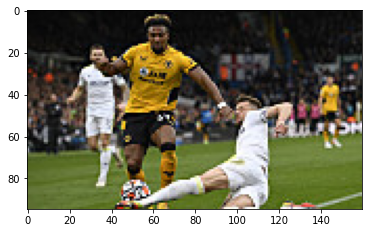

레전드의 일침 "김동엽, 타격 폼 바꾸다 은퇴하려 하는가"


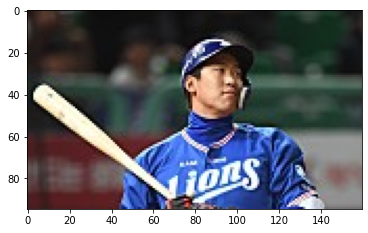

향년 35세, 3년 전 떠난 '천재'…아스널, "우린 영원히 그를 기억할 것"


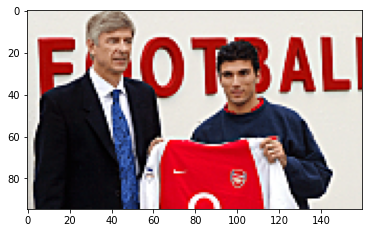

출범 초기부터 반복된 참사…이용수 체제, 제 기능을 하고 있나?


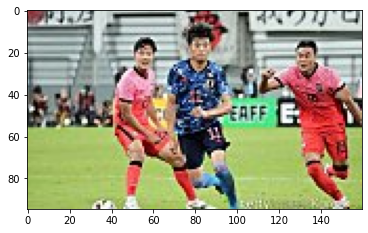

日축구 레전드 조 쇼지, “한국축구 끔찍했다. 이제 숙명의 라이벌 아냐”


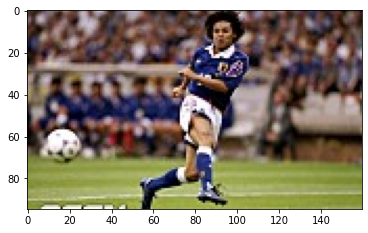

골스, 라이언 롤린스와 3년 ‘62억 원’ 계약[오피셜]


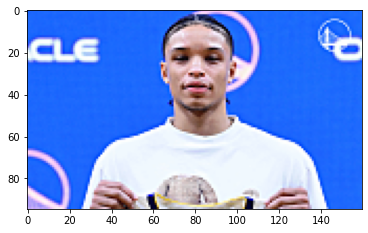

In [8]:
for (text, image) in pairs:
    print(text)
    plt.imshow(image)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dict_keys(['input_ids', 'attention_mask', 'pixel_values'])
torch.Size([6, 61])
torch.Size([6, 61])
torch.Size([6, 3, 224, 224])
콘테 러브콜도 거절하더니... 이젠 불러주는 팀 없는 '괴물'
tensor([49406,   168,   121,   246,   169,   227,   490,   167,   253, 31736,
          116,   234,   168,   121,   250, 31972,   482,   166,   109,   108,
        20580,   230, 33992, 45543,   242, 13094,   486,   678, 12286, 20580,
          510,   167,   114,   230,   167,   253,   105, 45161,   167,   232,
          498,   169,   234,   478, 13252,   228,   167,   232,   498,   262,
          166,   112,   112,   167,   105,   376,   262, 49407, 49407, 49407,
        49407])


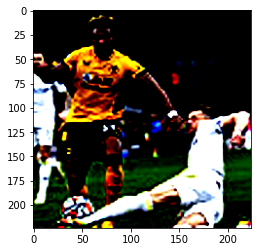

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


레전드의 일침 "김동엽, 타격 폼 바꾸다 은퇴하려 하는가"
tensor([49406,   167, 43364, 20580,   226, 30850,   250,  8276,   502, 43406,
        45088,   357,   257, 25203, 31972,   247, 13252,   377,   267, 41126,
        35555,   358,   169,   237,   376, 15810,   242,   166,   122,   116,
        13094,   353,  8276,   222,   169,   229,   112, 33992,   167,   254,
          353, 33992,   167,   232,   242, 21122,   478,   257, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407])


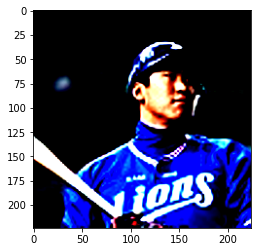

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


향년 35세, 3년 전 떠난 '천재'…아스널, "우린 영원히 그를 기억할 것"
tensor([49406,   169,   244,    98,   167,   227,   482,   274,   276, 15074,
          372,   267,   274,   167,   227,   482, 20580,   482,   167,   244,
          254, 27252,   506,   262,   168,   110,   250, 20849,   361, 42120,
        23233, 20305,   167,   226,   494,   267,   257, 38415, 24621,   364,
        21144,   223, 22543,   238,   169,   252,   486, 42680, 19693,    98,
          376, 32495,   108, 31625,   113, 15197,   510, 35555,   481,   257,
        49407])


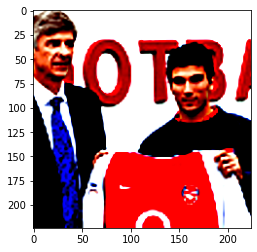

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


출범 초기부터 반복된 참사…이용수 체제, 제 기능을 하고 있나?
tensor([49406, 42476, 39810,   110,   498,   168,   112,   230, 32495,   108,
          167,   114,   222,   169,   226,   364, 15810,   246, 44693,   113,
          167,   238,   506, 40742,   116, 31061,   361,   959, 12286, 18541,
          102, 32757,   502,   168,   110,   112, 20580,   506,   267, 20580,
          506, 32495,   108,   167,   232,    98,  8276,   482, 33992, 36216,
          510, 20849,   230, 27252,   502,   286, 49407, 49407, 49407, 49407,
        49407])


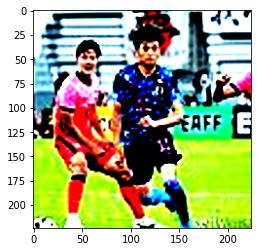

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


日축구 레전드 조 쇼지, “한국축구 끔찍했다. 이제 숙명의 라이벌 아냐”
tensor([49406, 39121, 46403, 31871,   361,   167, 43364, 20580,   226, 30850,
          506,   168,    94,   364,   168,   229,   120, 16279,   478,   267,
          728,   506, 15197,   250, 31871,   255, 46403, 31871,   361,   167,
          223,   242, 40742,   235,   169,   244,   230, 13094,   353,   269,
        12286, 20580,   506, 32757,   247, 36311,   227,  8276,   502, 44317,
          120, 12286, 48267,   490, 23233,   167,   225,   494,   728,   507,
        49407])


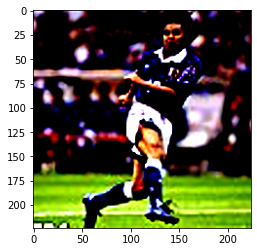

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


골스, 라이언 롤린스와 3년 ‘62억 원’ 계약[오피셜]
tensor([49406, 36216,   101, 23829,   267, 44317,   120, 12286, 31625,   372,
          167,    94,    97, 24621,   108, 20305, 39405,   478,   274,   167,
          227,   482,   728,   502,   277,   273, 31625,   369, 36495,   728,
          503, 36216,   226, 16071,   377,   314, 21144,    97, 29450,   120,
          168,   227,   506,   316, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407])


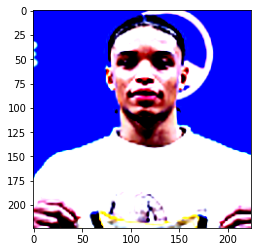

In [9]:
text_list = [x[0] for x in pairs]
image_list = [x[1] for x in pairs]

inputs = processor(text=text_list, images=image_list, return_tensors="pt", padding=True, truncation=True)

print(inputs.keys())
print(inputs.input_ids.shape)
print(inputs.attention_mask.shape)
print(inputs.pixel_values.shape)

for text, input_id, pixel_values in zip(text_list, inputs.input_ids, inputs.pixel_values):
    print(text)
    print(input_id)
    plt.imshow(pixel_values.numpy().transpose(1, 2, 0))
    plt.show()

In [10]:
inputs = {key: tensor.cuda() for key, tensor in inputs.items()}
outputs = model(**inputs, return_loss=True)
print(outputs.keys())
print(outputs.loss)
print(outputs.image_embeds.shape)
print(outputs.text_embeds.shape)
print(outputs.logits_per_image)
print(outputs.logits_per_text)


odict_keys(['loss', 'logits_per_image', 'logits_per_text', 'text_embeds', 'image_embeds', 'text_model_output', 'vision_model_output'])
tensor(4.5260, device='cuda:0', grad_fn=<DivBackward0>)
torch.Size([6, 512])
torch.Size([6, 512])
tensor([[15.3464, 14.1240, 11.9977, 14.7791, 16.6855, 13.2604],
        [23.6662, 23.5240, 22.1060, 23.9911, 24.2884, 24.0989],
        [12.5987, 12.3788,  9.2119, 12.4751, 11.7508, 12.2989],
        [22.0135, 22.7176, 19.5447, 23.7017, 29.2598, 23.0186],
        [19.3655, 19.7633, 18.1233, 19.6622, 22.8548, 19.2112],
        [19.3936, 19.1024, 15.8943, 18.6731, 18.3645, 16.9660]],
       device='cuda:0', grad_fn=<PermuteBackward0>)
tensor([[15.3464, 23.6662, 12.5987, 22.0135, 19.3655, 19.3936],
        [14.1240, 23.5240, 12.3788, 22.7176, 19.7633, 19.1024],
        [11.9977, 22.1060,  9.2119, 19.5447, 18.1233, 15.8943],
        [14.7791, 23.9911, 12.4751, 23.7017, 19.6622, 18.6731],
        [16.6855, 24.2884, 11.7508, 29.2598, 22.8548, 18.3645],
        [1

# 3. Application

## 3만여 문장으로 구성되어있는 multi30k 데이터셋을 로딩하여, 앞선 예제에서 크롤링한 네이버 뉴스 사진과 유사도가 높은 문장을 찾아봅시다.

In [11]:
! mkdir data
! wget https://github.com/multi30k/dataset/raw/master/data/task1/raw/train.en.gz -O data/labels.gz
! gzip -d data/labels.gz

���� ���͸� �Ǵ� ���� data��(��) �̹� �ֽ��ϴ�.
--2022-07-29 16:45:31--  https://github.com/multi30k/dataset/raw/master/data/task1/raw/train.en.gz
Resolving github.com (github.com)... 52.78.231.108
Connecting to github.com (github.com)|52.78.231.108|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/train.en.gz [following]
--2022-07-29 16:45:31--  https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/train.en.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 568929 (556K) [application/octet-stream]
Saving to: 'data/labels.gz'

     0K .......... .......... .......... .......... ..........  8% 12.0M 0s
    50K .......... .......... .......... ..

In [13]:
with open('data/labels', 'r') as f:
    labels = [text.strip() for text in f]
print(len(labels), labels[:5])

29000 ['Two young, White males are outside near many bushes.', 'Several men in hard hats are operating a giant pulley system.', 'A little girl climbing into a wooden playhouse.', 'A man in a blue shirt is standing on a ladder cleaning a window.', 'Two men are at the stove preparing food.']


In [14]:
decoded = processor(text=labels, return_tensors='pt', padding=True)
print(decoded.input_ids.shape)

torch.Size([29000, 47])


이 정도 크기의 batch를 한번에 model에 태우면 GPU 메모리가 부족해집니다.

### PyTorch Tip!
대량의 labels 데이터를 mini-batch로 나누어 로딩하기 위해 PyTorch 에서 제공하는 데이터로더를 사용하봅시다.

우리가 사용할 labels 는 어떠한 프리프로세싱도 거치지 않은 파이썬 string 리스트입니다. PyTorch 모델의 입력으로 사용하기 위해서는 전처리기에 통과시켜 줘야하겠지요?

이를 위하여 Collate Function 기능을 이용해보겠습니다. Collate Function 은 PyTorch Dataloader 가 mini-batch 단위로 반환하는 데이터 묶음 리스트를 받아서 적절한 형태 (예: PyTorch 텐서 객체) 로 처리하는 역할을 합니다.

Collate Function 에 대한 자세한 내용은 다음 링크를 참고해주세요:
https://pytorch.org/docs/stable/data.html#working-with-collate-fn


In [15]:
class CollateFunction:
  def __init__(self):
      self.processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
  
  def __call__(self, sentences):
      return self.processor(text=sentences, return_tensors='pt', padding=True)
  
collator = CollateFunction()
print(collator(['text', 'text2']))

{'input_ids': tensor([[49406,  4160, 49407, 49407],
        [49406,  4160,   273, 49407]]), 'attention_mask': tensor([[1, 1, 1, 0],
        [1, 1, 1, 1]])}


In [16]:
import torch
from torch.utils.data import DataLoader

import numpy as np

from tqdm.notebook import tqdm

loader = DataLoader(labels, batch_size=256, shuffle=None, num_workers=0, collate_fn=collator)

text_embed_list = []

for batch in tqdm(loader, "Embedding"):
    batch = {k: v.cuda() for k, v in batch.items()}

    with torch.no_grad():
      output = model.get_text_features(**batch)
    
    output = output.cpu().numpy()
    text_embed_list.append(output)

text_embed = np.concatenate(text_embed_list, axis=0)
print(text_embed.shape)

Embedding:   0%|          | 0/114 [00:00<?, ?it/s]

(29000, 512)


### 수 만개 크기의 데이터를 한 번에 계산하는 것은 일반적인 GPU 에서 불가능합니다 (메모리 부족).

사진이나 텍스트 임베딩의 수가 매우 많다면 `faiss` 라이브러리로 비슷한 vector를 찾아봅시다.

<p align="center">
<a href="https://github.com/facebookresearch/faiss">
<img src="https://engineering.fb.com/wp-content/uploads/2017/03/faiss_logo.png" width="500px"></img></a>
</p>
<p align="center"> <a href="https://github.com/facebookresearch/faiss"> Faiss </a> </p>

In [17]:
! pip install faiss-gpu

     ---------------------------------------- 40.3/40.3 kB ? eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Discarding https://files.pythonhosted.org/packages/17/76/47d0cc8161f4bf988583a2839bb1e56baf09d6b80cfa472b9eba4d5f543b/faiss-gpu-1.7.1.post2.tar.gz#sha256=877478752c03678fd9b9553e4ffadca82cd337bba9bb6a939aa1c6ea561a7a58 (from https://pypi.org/simple/faiss-gpu/): Requested faiss-cpu from https://files.pythonhosted.org/packages/17/76/47d0cc8161f4bf988583a2839bb1e56baf09d6b80cfa472b9eba4d5f543b/faiss-gpu-1.7.1.post2.tar.gz#sha256=877478752c03678fd9b9553e4ffadca82cd337bba9bb6a939aa1c6ea561a7a58 has inconsistent name: filename has 'faiss-gpu', but metadata has 'faiss-cpu'
     ---------------------------------------- 41.1/41.1 kB ? eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Discarding https://files.pythonhosted.org/packages/39/8d/b62bc92c8dd4b2a99d4a

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [7 lines of output]
      running egg_info
      creating C:\Users\AI_15\AppData\Local\Temp\pip-pip-egg-info-9dnrqoh0\faiss_cpu.egg-info
      writing C:\Users\AI_15\AppData\Local\Temp\pip-pip-egg-info-9dnrqoh0\faiss_cpu.egg-info\PKG-INFO
      writing dependency_links to C:\Users\AI_15\AppData\Local\Temp\pip-pip-egg-info-9dnrqoh0\faiss_cpu.egg-info\dependency_links.txt
      writing top-level names to C:\Users\AI_15\AppData\Local\Temp\pip-pip-egg-info-9dnrqoh0\faiss_cpu.egg-info\top_level.txt
      writing manifest file 'C:\Users\AI_15\AppData\Local\Temp\pip-pip-egg-info-9dnrqoh0\faiss_cpu.egg-info\SOURCES.txt'
      error: package directory 'C:\Users\AI_15\AppData\Local\Temp\pip-install-x55lp0ha\faiss-gpu_4c7258ac229b46da84ebdc06a65d2d09\faiss\faiss\python' does not exist
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a pr

In [18]:
from faiss import IndexFlatL2
faiss_index = IndexFlatL2(512)
faiss_index.add(text_embed.astype(np.float32))
print(faiss_index.ntotal)

29000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dict_keys(['pixel_values'])
torch.Size([6, 3, 224, 224])


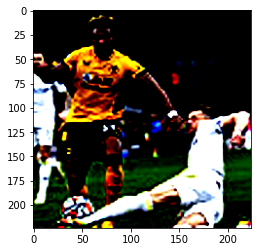

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


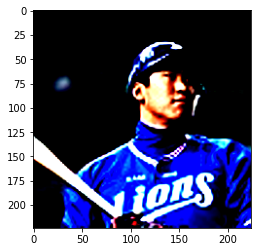

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


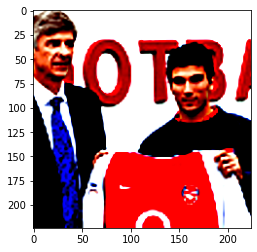

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


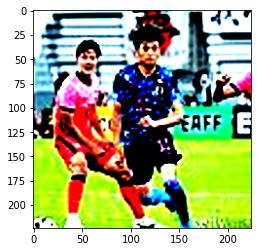

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


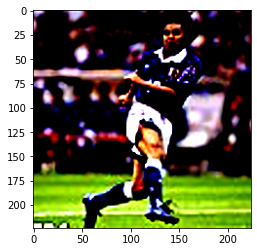

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


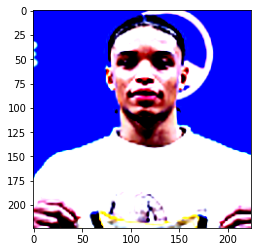

torch.Size([6, 512])


In [19]:
image_inputs = processor(images=image_list, return_tensors="pt")
print(image_inputs.keys())
print(image_inputs.pixel_values.shape)
for pixel_value in image_inputs.pixel_values:
    plt.imshow(pixel_value.numpy().transpose(1, 2, 0))
    plt.show()

with torch.no_grad():
  image_inputs = {key: tensor.cuda() for key, tensor in image_inputs.items()}
  image_encoding = model.get_image_features(**image_inputs)
print(image_encoding.shape)

[[103.52797  103.56016  105.34214 ]
 [113.73456  115.89396  116.532745]
 [108.58707  109.0814   109.867134]
 [108.03786  108.32701  108.51665 ]
 [104.33116  106.685104 107.10429 ]
 [ 99.656906  99.8591   100.7066  ]] [[12826 25433 14751]
 [ 5481  8439   251]
 [ 2209 17657  8889]
 [14185 19233  9263]
 [26027   670  4641]
 [24257  3724  1615]]


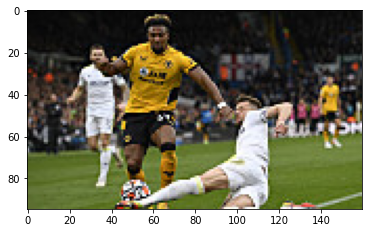

1 순위 매치: Three men climbing on each other wearing yellow and brown shirts.
2 순위 매치: Blond man in a black suit with yellow shoes in jumping over a hurdle.
3 순위 매치: A boy in a yellow shirt and blue jeans jumps over exercise pylons while two boys dressed in soccer uniforms look on.


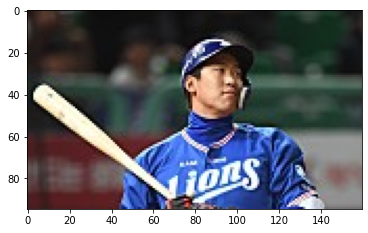

1 순위 매치: A team of baseball players in blue uniforms, walking together on field.
2 순위 매치: A young boy in a blue jacket swings a bat at a ball.
3 순위 매치: A young Asian boy sits on a railing behind a row of colorful hats


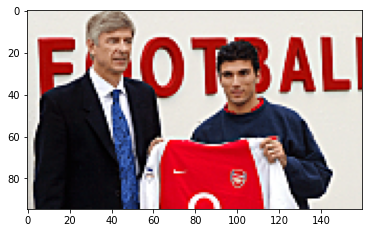

1 순위 매치: Three men in camouflage clothing and another man in a hat and red shirt and blue shorts standing in front of a building.
2 순위 매치: Two dark-haired men in orange shirts leaning on a desk next to a man in a uniform.
3 순위 매치: A man with glasses, a coat and scarf stands in front of a blue wall with an open book.


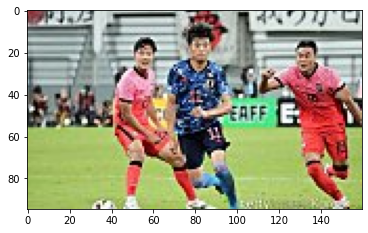

1 순위 매치: A young boy carrying a large soccer ball with a soccer feild in the background
2 순위 매치: Three people are playing soccer, one wearing orange, two wearing blue of which one is in the midst of jumping in the air.
3 순위 매치: Two boys in blue shirts fighting behind a gray car and two other children.


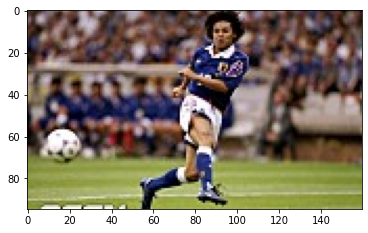

1 순위 매치: Woman in blue shorts and white shirt kicking a soccer ball.
2 순위 매치: Young girl in blue dress stepping over a soccer ball.
3 순위 매치: A girl in a pink jersey and green knee high socks kicks a soccer ball.


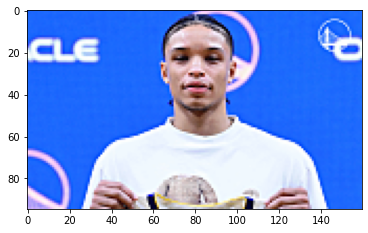

1 순위 매치: Sunglasses wearing young white boy is standing in a field of white flowers and holding a soccer ball.
2 순위 매치: Young man in white long-sleeved shirt standing in front of mountains on a cloudy day.
3 순위 매치: A man with medium length hair, wearing a red beanie and blue shorts with no shirt, on one knee at the beach, sculpting a sand castle with a trough.


In [20]:
K = 3
distance, text_indices = faiss_index.search(image_encoding.cpu().numpy(), k=K)
print(distance, text_indices)

for sample_id, text_index in enumerate(text_indices):
  image_array = np.array(image_list[sample_id])
  plt.imshow(image_array)
  plt.show()
  for rank in range(K):
    print(f"{rank+1} 순위 매치: {labels[text_index[rank]]}")